# Project 2: Web Traffic Analysis
**This is the second of three mandatory projects to be handed in as part of the assessment for the course 02807 Computational Tools for Data Science at Technical University of Denmark, autumn 2019.**

#### Practical info
- **The project is to be done in groups of at most 3 students**
- **Each group has to hand in _one_ Jupyter notebook (this notebook) with their solution**
- **The hand-in of the notebook is due 2019-11-10, 23:59 on DTU Inside**

#### Your solution
- **Your solution should be in Python**
- **For each question you may use as many cells for your solution as you like**
- **You should document your solution and explain the choices you've made (for example by using multiple cells and use Markdown to assist the reader of the notebook)**
- **You should not remove the problem statements**
- **Your notebook should be runnable, i.e., clicking [>>] in Jupyter should generate the result that you want to be assessed**
- **You are not expected to use machine learning to solve any of the exercises**
- **You will be assessed according to correctness and readability of your code, choice of solution, choice of tools and libraries, and documentation of your solution**

## Introduction
In this project your task is to analyze a stream of log entries. A log entry consists of an [IP address](https://en.wikipedia.org/wiki/IP_address) and a [domain name](https://en.wikipedia.org/wiki/Domain_name). For example, a log line may look as follows:

`192.168.0.1 somedomain.dk`

One log line is the result of the event that the domain name was visited by someone having the corresponding IP address. Your task is to analyze the traffic on a number of domains. Counting the number of unique IPs seen on a domain doesn't correspond to the exact number of unique visitors, but it is a good estimate.

Specifically, you should answer the following questions from the stream of log entries.

- How many unique IPs are there in the stream?
- How many unique IPs are there for each domain?
- How many times was IP X seen on domain Y? (for some X and Y provided at run time)

**The answers to these questions can be approximate!**

You should also try to answer one or more of the following, more advanced, questions. The answers to these should also be approximate.

- How many unique IPs are there for the domains $d_1, d_2, \ldots$?
- How many times was IP X seen on domains $d_1, d_2, \ldots$?
- What are the X most frequent IPs in the stream?

You should use algorithms and data structures that you've learned about in the lectures, and you should provide your own implementations of these.

Furthermore, you are expected to:

- Document the accuracy of your answers when using algorithms that give approximate answers
- Argue why you are using certain parameters for your data structures

This notebook is in three parts. In the first part you are given an example of how to read from the stream (which for the purpose of this project is a remote file). In the second part you should implement the algorithms and data structures that you intend to use, and in the last part you should use these for analyzing the stream.

## Reading the stream
The following code reads a remote file line by line. It is wrapped in a generator to make it easier to extend. You may modify this if you want to, but your solution should remain parametrized, so that your notebook can be run without having to consume the entire file.

In [1]:
import urllib

def stream(n):
    i = 0
#    with urllib.request.urlopen('https://02807-comp-tools.s3.us-east-2.amazonaws.com/traffic') as f:
    with urllib.request.urlopen('https://files.dtu.dk/fss/public/link/public/stream/read/traffic_2?linkToken=_DcyO-U3MjjuNzI-&itemName=traffic_2') as f:
        for line in f:
            element = line.rstrip().decode("utf-8")
            yield element
            i += 1
            if i == n:
                break

In [2]:
STREAM_SIZE = 10000
web_traffic_stream = stream(STREAM_SIZE)

## Data structures

Follows an implementation of the **HyperLogLog** algorithm based on the *program* shown in Figure 3 of [\[1\]](#reference-1). As explained in *Section 4* of the paper, the initialization of the registers is set at $0$, which would mean that, when $n << m\log m$ we have $E = 0$ which means that for small cardinalities the algorithm is making a big approximation error. In most practical applications however, it will hold that $n>>m \log m$, which means that all registers are non-empty and the estimate of the cardinality is correct. A small range correction is applied to deal with the case where cardinality is small, in particular, when it's $n < \frac{5}{2}m$ (where $n$ is the true cardinality of the multiset) the algorithm makes use of the number of empty registers to estimate the true cardinality with higher precision. Another similar problem arises when we are trying to estimate a cardinality of order greater than $2^{L}$ (where $L$ is the number of bits used by the hash function). When this happens, collisions are much more likely to happen and a correction is therefore applied.

In [3]:
import mmh3
import math
class HyperLOGLOG:
    def __init__(self, b, hash_bits = 32 ):
        """
        b: number of bits that define m = 2^b, the number of registers used
        hash_bits: number of bits in the hashed value
        """
        # too little registers would not make this perform well
        if b<4:
            raise ValueError("Use at least 4 bits for the number of registers.")
        
        # different types of hash functions
        self.hash_bits = hash_bits
        if hash_bits == 32:
            self.hashf = mmh3.hash
        elif hash_bits == 64:
            self.hashf = mmh3.hash64
        elif hash_bits == 128:
            self.hashf = mmh3.hash128
        else:
            raise ValueError("Hash function length not recognized. Choose between 32, 64 or 128 bits.")
       
        #number of bits defining the number of registers
        self.b = b
        
        # the number of registers needs to be less than the number of values the hash can have
        if self.b > self.hash_bits:
            raise ValueError("Number of bits ({}) is bigger than the length of the hash function ({})".format(self.b, self.hash_bits))
        
        # number of registers
        self.m = 2 ** b
        
        # the list of registers, initialized to 0
        self.M = [ 0 for i in range(self.m) ]
    def add_element(self, element):
        
        # get the hased value
        x =  self.hashf(element, 1, signed = False)
        
        # get the last b bits
        idx = x & (self.m - 1)
        
        # get the first hash_bits-b bits
        w = x >> self.b
        
        # update the respective register
        self.M[idx] = max(self.M[idx], self.get_rho(w, self.hash_bits - self.b))
    
    def get_rho(self, w, max_len):
        # if w.bit_length == 0 then it return max_len + 1 as intended
        return max_len - w.bit_length() + 1
    
    def get_mlogm(self):
        # this is used for analysis
        return self.m*math.log(self.m,2)
    
    def get_alpha(self):
        #values according to the paper
        if self.m == 16:
            return 0.673
        
        if self.m == 32:
            return 0.697
        
        if self.m == 64:
            return 0.709

        return 0.7213/(1+1.079/self.m)
    
    def get_cardinality(self):
        # initial estimate of cardinality is 0
        E = 0
        m = self.m
        alpha = self.get_alpha()
        cur_sum = 0
        # number of empty registers
        V = 0
        
        # go through all registers and start computing the harmonic mean
        # also count the number of empty registers
        for i in range(len(self.M)):
            if self.M[i] == 0:
                V += 1
            cur_sum += math.pow(2,(-self.M[i]))
        # raw HyperLogLog estimate
        E = alpha*(m**2)/cur_sum
        # corrected HyperLogLog estimate
        E_star = 0
        
        if E <= 5*m/2:
            # small range
            if V != 0:
                E_star = m*math.log(m/V)
            else:
                E_star = E
        elif E <= 1/30*2**self.hash_bits:
            # intermediate range
            E_star = E
        else:
            # large range
            E_star = -(2**self.hash_bits)*math.log(1-E/(w**self.hash_bits))
        return E_star
    
    def get_relative_error(self):
        # compute relative error as described in the paper
        return 1.04/math.sqrt(self.m)
    
    def merge(self, hll):
        # merge with another HyperLogLog
        if self.b != hll.b:
            raise ValueError("The number of registers must be the same, current number of bits: {}".format(self.b))
        if self.hash_bits != hll.hash_bits:
            raise ValueError("The hash function used must be the same, current hash function uses {} bits".format(self.hash_bits))
                
        for i in range(len(merged_hll.M)):
            self.M[i] = max(self.M[i], hll.M[i])

def merge_two_hlls(hll1, hll2):
    #merge two HyperLogLogs into a new one
    # check parameters
    if hll1.b != hll2.b:
        raise ValueError("The number of registers must be the same")
    if hll1.hash_bits != hll2.hash_bits:
        raise ValueError("The hash function used must be the same")
    
    merged_hll = HyperLOGLOG(hll1.b, hll1.hash_bits)
    
    for i in range(len(merged_hll.M)):
        merged_hll.M[i] = max(hll1.M[i], hll2.M[i])
    return merged_hll
def merge_hlls_list(hlls):
    if len(hlls) == 0:
        raise ValueError("The list of HyperLogLog is empty")
    b = hlls[0].b
    hash_bits = hlls[0].hash_bits
    # make sure all properties are the same, otherwise I can't merge
    for hll in hlls:
        if hll.b != b:
            raise ValueError("The number of registers must be the same for all HyperLogLogs")
        if hll.hash_bits != hash_bits:
            raise ValueError("The hash function used must be the same for all HyperLogLogs")
    # create a new HyperLogLog
    merged_hll = HyperLOGLOG(b, hash_bits)
    # merge the registers
    for i in range(len(merged_hll.M)):
        merged_hll.M[i] = max([hll.M[i] for hll in hlls])
    return merged_hll

**Explanation of merge**. When we process the first stream, the *HyperLogLog* algorithm split the stream in substreams according to the hashing function (by picking the *b* most significant bits as index) then we are storing the position of the most significant 1 in the binary representation of all the hashes that we have seen in substream $j$ (let's call this $\rho_1$). If we add a new stream of data, we could just run the algorithm on this second stream first, which would find the $\rho_2$. If we want to now the $\rho_T$ of both streams we can just find the maximum by taking the maximum between $\rho_1$ and $\rho_2$. The *HyperLogLog* is in fact highly parallelizable.

In [4]:
# used to split the string into ip and domain
def parse_stream(input_string):
    return input_string.split("\t")

In [5]:
def cardinality_stream(hlls):
    """
    hlls: the data structure containing the HyperLogLogs for each domain encoutered in the stream
    """
    merged_hlls = merge_hlls_list(list(hlls.values()))
    return merged_hlls.get_cardinality(), merged_hlls.get_relative_error()


In [6]:
# retrieve the cardinality for each domain
def cardinality_each_domain(hlls):
    """
    hlls: the data structure containing the HyperLogLogs for each domain encoutered in the stream
    """
    cardinalities = {}
    for domain in hlls.keys():
        cardinalities[domain] = hlls[domain].get_cardinality()
    return cardinalities
  

if we don't expect to be asked of a specific subset of domains before we process the stream, we need to process information about all of them separately and then merge the information when the cardinality is requested and the domains are specified.

In [7]:
def cardinality_union_domains(hlls, domains):
    """
    hlls: the data structure containing the HyperLogLogs for each domain encoutered in the stream
    domains: the list of domains for which the cumulative cardinality wants to be known
    """
    to_merge = [hll for domain, hll in hlls.items() if domain in domains]
    if len(to_merge) == 0:
        return 0
    else:
        return merge_hlls_list(to_merge).get_cardinality()

### CountMin Sketch

In [8]:
# borrowing code from the bisect library and adapted by user John La Rooy on Stack Overflow to insert in 
# reverse order (source: https://stackoverflow.com/questions/2247394/bisect-is-it-possible-to-work-with-descending-sorted-lists)
def reverse_insort(a, x, lo=0, hi=None):
    """Insert item x in list a, and keep it reverse-sorted assuming a
    is reverse-sorted.

    If x is already in a, insert it to the right of the rightmost x.

    Optional args lo (default 0) and hi (default len(a)) bound the
    slice of a to be searched.
    """
    if lo < 0:
        raise ValueError('lo must be non-negative')
    if hi is None:
        hi = len(a)
    while lo < hi:
        mid = (lo+hi)//2
        if x > a[mid]: hi = mid
        else: lo = mid+1
    a.insert(lo, x)

In [9]:
class CountMin:
    def __init__(self, d, w, X = None):
        """
        b: number of rows
        w: number of columns
        X: number of most frequent IPs to memorize, if None the operation is not performed
        """
        #number of rows in the array
        self.d = d
        #numbner of columns in the array
        self.w = w
        #the array
        self.h = []
        #initialize the array to zeros
        for j in range(d):
            self.h.append([0]*w)
            
        self.eps = 2.0 / w;
        self.confidence = 1 - 1 / (2 ** d);
        # to keep track of top X most frequent ips
        self.X = X
        self.top_X = []
            
    def add_element(self, element):
        #update all the columns in the hash counter array
        for j in range(self.d):
            hashed_element = mmh3.hash(element, j, signed = False)%self.w
            self.h[j][hashed_element] += 1
        # update frequency list
        if self.X != None:
            #use fast insertion in sorted array (to update the frequensy counting list)
            reverse_insort(self.top_X, (self.get_count(element), element))
            self.top_X = (self.top_X)[:self.X]
            
    def get_count(self, element):
        #get the first count to initialize the minimum
        hashed_element = mmh3.hash(element, 0, signed = False)%self.w
        #initialize minimum
        estimate_count = self.h[0][hashed_element]
        #find the actual minimum
        for j in range(1, self.d):
            hashed_element = mmh3.hash(element, j, signed = False)%self.w
            cur_count = self.h[j][hashed_element]
            if cur_count < estimate_count:
                estimate_count = cur_count
        return estimate_count
    def get_appr_param(self):
        return (self.eps,self.confidence)

def merge_cms_list(cms):
    if len(cms) == 0:
        raise ValueError("The list of CountMins is empty")
    d = cms[0].d
    w = cms[0].w
    # make sure all properties are the same, otherwise it can't merge
    for cm in cms:
        if cm.d != d:
            raise ValueError("The number of rows must be the same for all CountMins")
        if cm.w != w:
            raise ValueError("The number of columns must be the same for all CountMins")
    # create a new CountMin
    merged_cm = CountMin(d,w)
    # merge the arrays
    for j in range(d):
        for i in range(w):
            merged_cm.h[j][i] = sum([cur_cm.h[j][i] for cur_cm in cms])
    return merged_cm

In [10]:
def get_count_domain(cms, ip, domain):
    """
    cms: CountMin sketch
    ip: IP address
    domain: Domain name
    """
    if domain not in cms.keys():
        return 0, (0,0)
    return cms[domain].get_count(ip), cms[domain].get_appr_param()

In [11]:
def count_union_domains(cms, domains, ip):
    to_merge = [cm for domain, cm in cms.items() if domain in domains]
    if len(to_merge) == 0:
        return 0, (0,0)
    else:
        merged_cm = merge_cms_list(to_merge)
        return merged_cm.get_count(ip), merged_cm.get_appr_param()

### Processing the stream

In [12]:
# create all the data structures needed
def process_stream(stream, X = 10):
    hlls_domain = {}
    cms_domain = {}
    # CountMin params
    d = 10
    w = 30000
    
    
    # HyperLogLog params
    b = 12
    
    cm_frequency = CountMin(d, w, X)
    
    # go through traffic
    parsed_traffic = map(parse_stream, stream)
    for ip, domain in parsed_traffic:
        
        if domain not in cms_domain.keys():
            cms_domain[domain] = CountMin(d, w)
        if domain not in hlls_domain.keys():
            hlls_domain[domain] = HyperLOGLOG(b)
        # add ip to the HyperLogLog for each domain
        hlls_domain[domain].add_element(ip)
        # add ip to the CountMin for each domain
        cms_domain[domain].add_element(ip)
        # add ip to the CountMin and keep top X frequency info
        cm_frequency.add_element(ip)
        
    return hlls_domain, cms_domain, cm_frequency

For the HyperLogLog the assumption is that the number of domains we will see in the stream is constant compared to the size of the stream, so we keep information separately for each domain and later merge it.

When it comes to the CountMin sketch, we need to keep information about each domain in the stream if we want to later answer a question about a specific IP and a specific domain, so the same assumption on the limited number of domains is made. Furthermore, to answer the question on the $X$ most frequent IPs seen in the stream we need to know before processing the stream the value for $X$, or at least an upperbound of it.

In [13]:
%%time
X = 10 #CHANGE TO DESIRED NUMBER OF TOP FREQUENSIES HERE
hlls_domain, cms_domain, cm_frequency = process_stream(web_traffic_stream, X)

CPU times: user 1.03 s, sys: 22.2 ms, total: 1.05 s
Wall time: 1.12 s


**Comment on the parameters chosen:** 

When it comes to **HyperLogLog**, we noticed that, with the small, medium and long range corrections applied, the error made by the algorithm was quite small when a large number of registers was used. We therefore decided to go with $2^{16}$ registers, mainly because we expect to process traffic in the order of magnitude of $10^8$ at maximum. We keep the number of bits in the hashed value to 32bits, if the traffic increases and we have to process $10^{10}$ elements, we rely on the long-range corrections that would kick in at that point.

For the **CountMin** instead, we see that, the more rows and columns we add, the more precision we get on average on the estimate of the true count of the IPs. This is particularly true for this stream, where on average an IP will appear only once, the reason is because at some point we will start having collisions, which could mean that for some of the elements, the hashes coming from all hash functions point to registers that have at least a count of 2 in them, but we know that, since there are mostly no repetitions, this count will be very likely to be incorrect. The prior knowledge on the nature of the stream makes it so that we know that at a certain point we will start having problems. What we can hope is that our size is large enough to allow for better approximations once the stream because big enough that repetitions start happening. One thing that is important to note is that, while increasing the number of rows means more rows to go through and so a lot more computation every time a new element is added, increasing the number of columns doesn't increase computation time, since it just means that we are reducing the size of the co-domain of the hash function (it does however mean an increase in size of the array storing the counts).

## Answers

> How many unique IPs are there in the stream?

In [14]:
cardinality, relative_error = cardinality_stream(hlls_domain)

print("Approximate cardinality of the stream: {}".format(cardinality))

Approximate cardinality of the stream: 10344.441997977996


The relative error (formally *standard error*):

In [15]:
print("Standard error of the approximation: {}".format(relative_error))

Standard error of the approximation: 0.01625


> How many unique IPs are there for each domain?

In [16]:
cardinality_each_domain(hlls_domain)

{'python.org': 2761.8642314942176,
 'wikipedia.org': 5032.030255889734,
 'pandas.pydata.org': 1313.8975165714185,
 'dtu.dk': 278.239974578755,
 'google.com': 255.82532580862633,
 'databricks.com': 130.0426682965208,
 'github.com': 132.10770489181192,
 'spark.apache.org': 52.332898627508804,
 'datarobot.com': 14.023980439771513,
 'scala-lang.org': 1.0001220901843502}

Here the standard error will be the same as before, since we use the same number of registers.

> How many times was IP X seen on domain Y? (for some X and Y provided at run time)

In [17]:
X = "67.137.198.137"
Y = "python.org"

apprx_count, apprx_params = get_count_domain(cms_domain, X, Y)

print("Approximate count of IP {} in domain {}: {}".format(X, Y, apprx_count))

print("Confidence of {} of the relative error {}".format(apprx_params[1], apprx_params[0]) )

Approximate count of IP 67.137.198.137 in domain python.org: 1
Confidence of 0.9990234375 of the relative error 6.666666666666667e-05


>How many unique IPs are there for the domains  $d1,d2,...$ ?

In [18]:
cardinality_union_domains(hlls_domain, ["python.org", "wikipedia.org"])

7793.333074115578

Here the standard error will be the same as when we previously used the HyperLogLog, since we use the same parameters and we merge properly.

> How many times was IP X seen on domains  $d1,d2,...$ ?

In [19]:
X = "67.137.198.137"
domain_1 = "python.org"
domain_2 = "wikipedia.org"

domains = [domain_1, domain_2]
ip_amount, apprx_params = count_union_domains(cms_domain, domains, X)
print("The number of times {} was seen in the domains {} and {} was: {}".format(X,domain_1,domain_2,ip_amount))

The number of times 67.137.198.137 was seen in the domains python.org and wikipedia.org was: 1


> What are the X most frequent IPs in the stream?

In [20]:
# Most reoccuring IP address at the top
# The length of the list, X, can be defined in the process_stream definition if desired (default is 10)
print("Most frequent IP addresses in the stream:")
print("(Frequency , IP address)")
cm_frequency.top_X

Most frequent IP addresses in the stream:
(Frequency , IP address)


[(3, '57.29.200.127'),
 (3, '56.33.200.126'),
 (2, '72.187.84.158'),
 (2, '58.28.201.129'),
 (2, '57.29.200.127'),
 (2, '56.33.200.126'),
 (2, '56.31.199.129'),
 (2, '56.27.199.127'),
 (2, '55.33.199.128'),
 (2, '55.29.198.128')]

## Analysis

Follows a brief analysis on the performance of the algorithm when the parameters are changed.

The following cells are just here to show how we approached the analysis of the parameters, to provide further justification for the final choice we made.

In [21]:
import numpy as np

stream_sizes = np.logspace(1, 6, 10)

num_rows = [4,8,10]

num_columns = 30000

ip = "67.137.198.137"

results_cm = np.zeros((len(stream_sizes), len(num_rows)))
real_results_cm = np.zeros((len(stream_sizes), len(num_rows)))

a = 0
for cur_stream_size in stream_sizes:
    b = 0
    web_traffic_stream = stream(int(cur_stream_size))
    parsed_traffic = list(map(parse_stream, web_traffic_stream))
    ips = [x[0] for x in parsed_traffic]
    print("Currently processing {}th size of stream".format(a))
    for cur_rows in num_rows:
        cm = CountMin(cur_rows, num_columns)
        counts = {}
        for i in ips:
            cm.add_element(i)
            if i not in counts:
                counts[i] = 0
            counts[i] +=1
            
        real_results_cm[a][b] = sum(list(counts.values()))/len(counts.values())
        for ip in counts.keys():
            results_cm[a][b] += cm.get_count(ip)
        results_cm[a][b]/=len(counts.values())
        b+=1
    a+=1

Currently processing 0th size of stream
Currently processing 1th size of stream
Currently processing 2th size of stream
Currently processing 3th size of stream
Currently processing 4th size of stream
Currently processing 5th size of stream
Currently processing 6th size of stream
Currently processing 7th size of stream
Currently processing 8th size of stream
Currently processing 9th size of stream


In [22]:
import numpy as np

stream_sizes = np.logspace(1, 7, 10)

bit_sizes = [4,8,16]

results = np.zeros((len(stream_sizes), len(bit_sizes)))
real_results = np.zeros((len(stream_sizes), len(bit_sizes)))



a = 0
for cur_stream_size in stream_sizes:
    b = 0
    web_traffic_stream = stream(int(cur_stream_size))
    parsed_traffic = list(map(parse_stream, web_traffic_stream))
    ips = [x[0] for x in parsed_traffic]
    print("Currently processing {}th size of stream".format(a))
    for cur_bit_size in bit_sizes:
        hll = HyperLOGLOG(cur_bit_size)
        
        real_results[a][b] = len(set(ips))
        for i in ips:
            hll.add_element(i)
        
        results[a][b] = hll.get_cardinality()
        b+=1
    a+=1

Currently processing 0th size of stream
Currently processing 1th size of stream
Currently processing 2th size of stream
Currently processing 3th size of stream
Currently processing 4th size of stream
Currently processing 5th size of stream
Currently processing 6th size of stream
Currently processing 7th size of stream
Currently processing 8th size of stream
Currently processing 9th size of stream


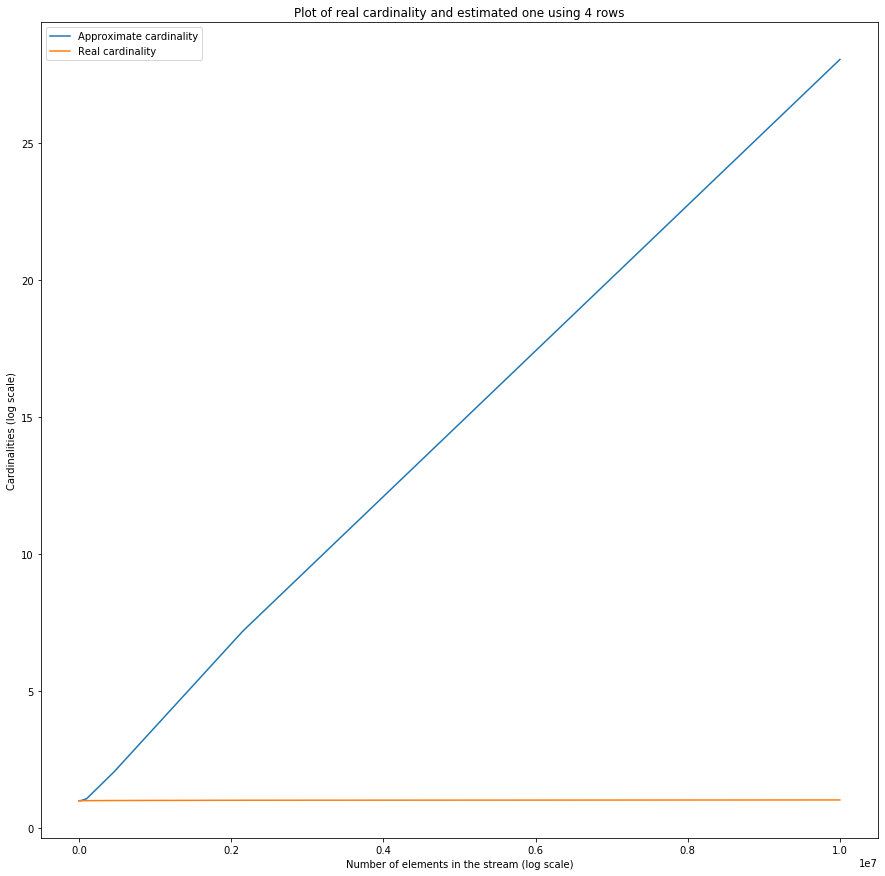

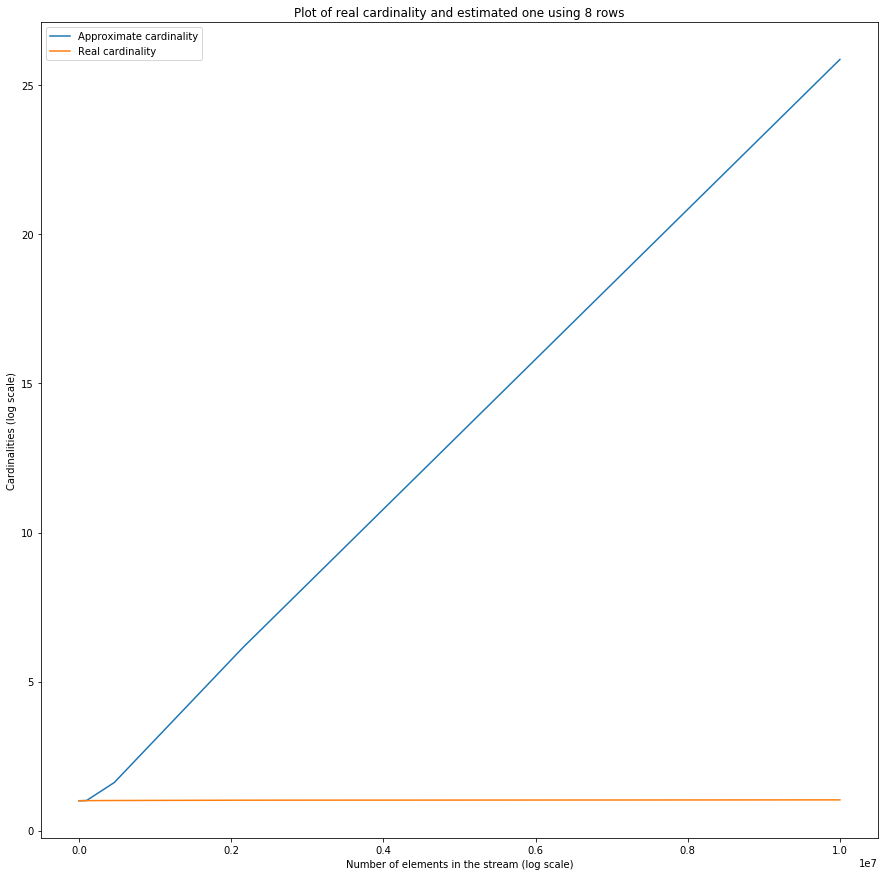

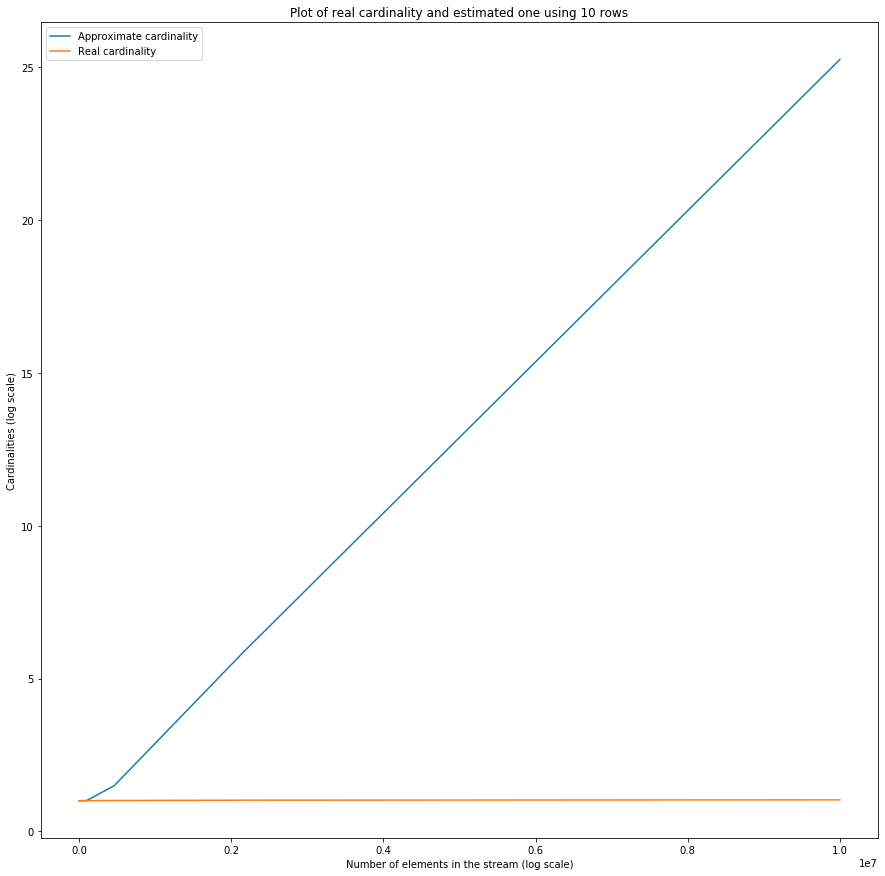

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
for i in range(len(bit_sizes)):
    plt.figure(figsize=(15,15))
    plt.title("Plot of real cardinality and estimated one using {} rows".format(num_rows[i]))    
    plt.plot((stream_sizes), (results_cm[:,i]), label = "Approximate cardinality")
    plt.plot((stream_sizes), (real_results_cm[:,i]), label = "Real cardinality")
    plt.xlabel("Number of elements in the stream (log scale)")
    plt.ylabel("Cardinalities (log scale)")
    plt.legend()
    plt.show()
    

In [24]:
for i in range(len(bit_sizes)):
    print("Mean relative error with {} registers: {}".format(2**bit_sizes[i], np.mean((results[:,i]-real_results[:,i])/results[:,i])))


Mean relative error with 16 registers: -0.016450567577614074
Mean relative error with 256 registers: -0.0025649659669505333
Mean relative error with 65536 registers: 0.0003339574080031285


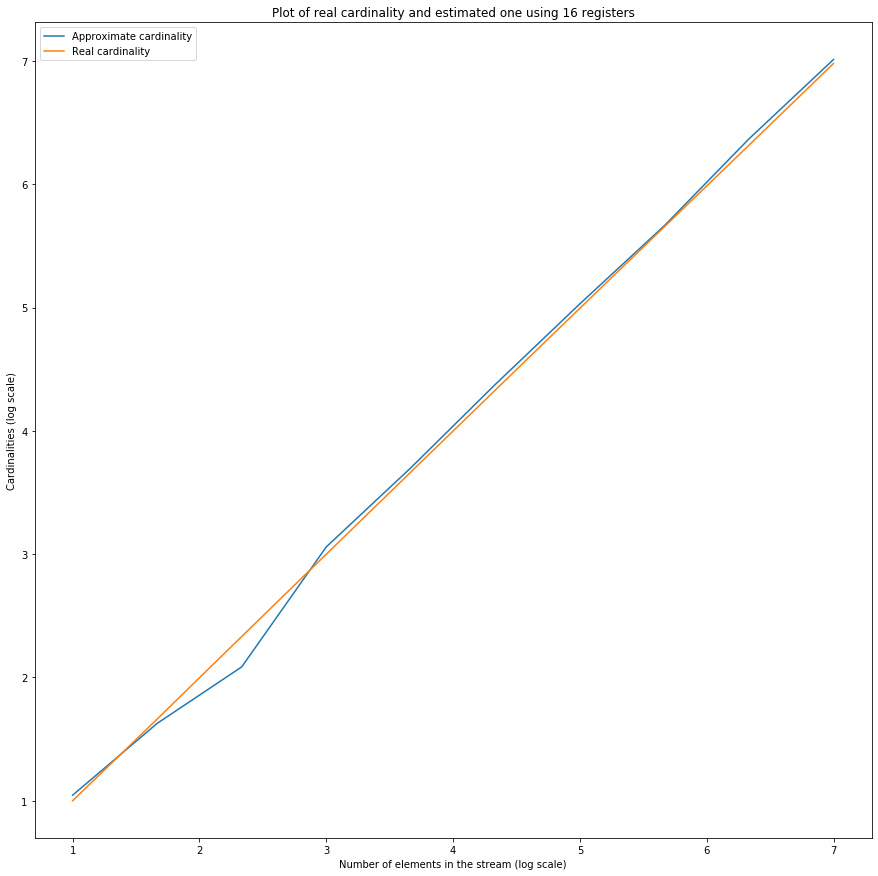

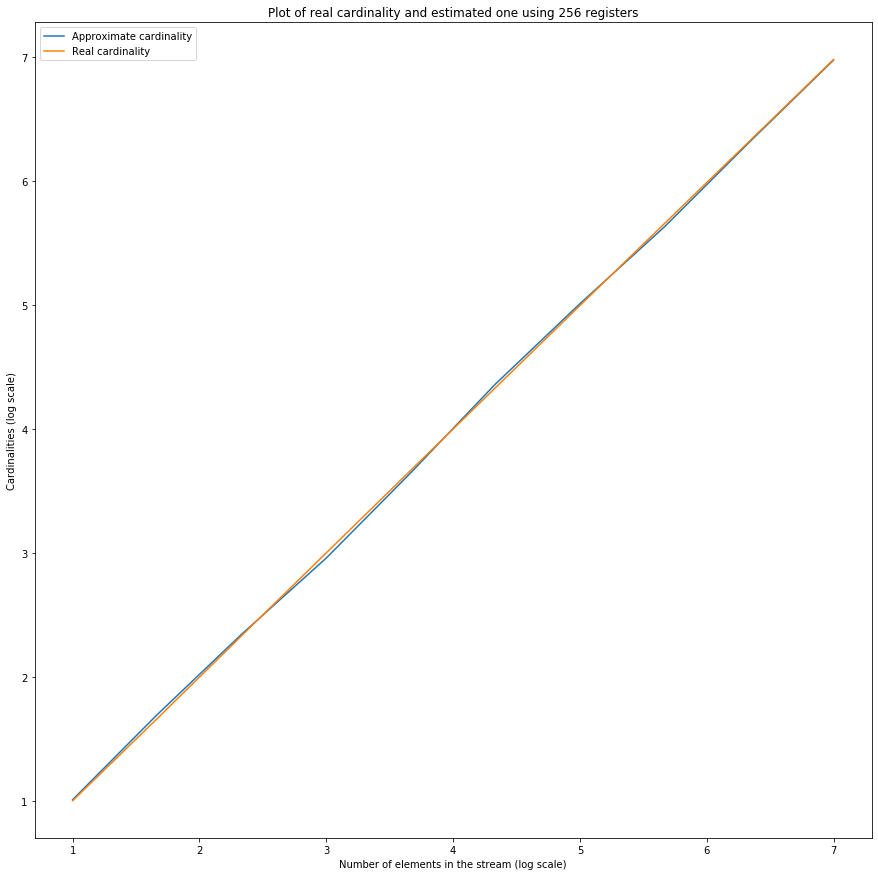

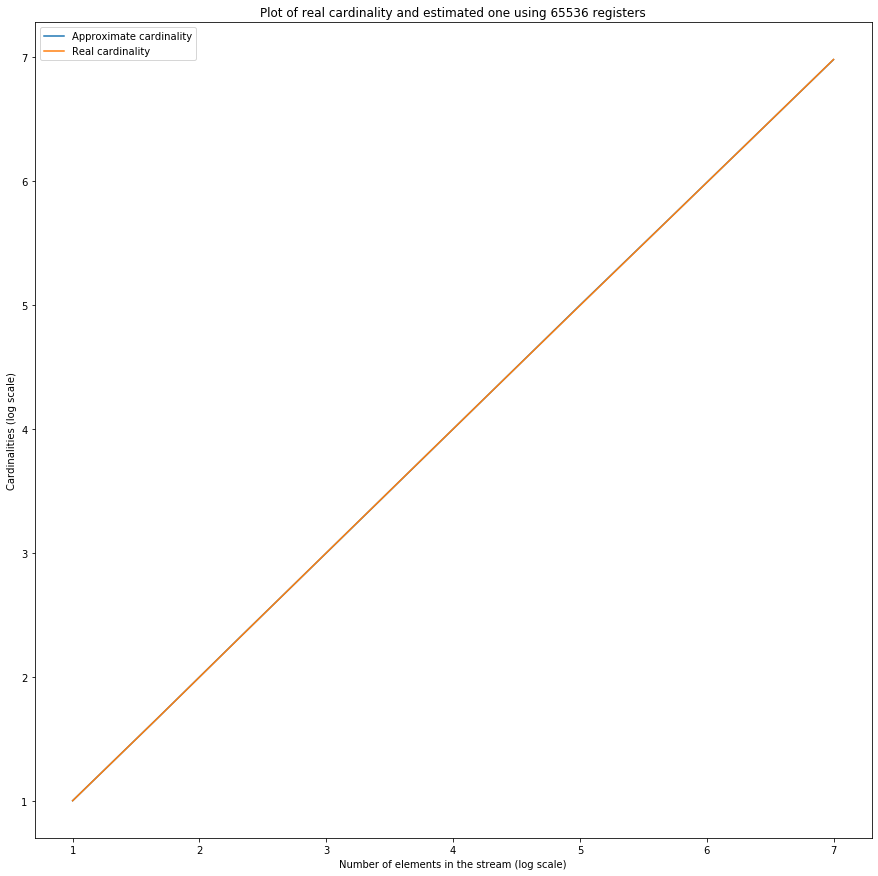

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
for i in range(len(bit_sizes)):
    plt.figure(figsize=(15,15))
    plt.title("Plot of real cardinality and estimated one using {} registers".format(2**bit_sizes[i]))    
    plt.plot(np.log10(stream_sizes), np.log10(results[:,i]), label = "Approximate cardinality")
    plt.plot(np.log10(stream_sizes), np.log10(real_results[:,i]), label = "Real cardinality")
    plt.xlabel("Number of elements in the stream (log scale)")
    plt.ylabel("Cardinalities (log scale)")
    plt.legend()
    plt.show()
    

Below are functions that were used in the analysis of the data structures.

In [26]:
def countmin_stream_most_frequent(stream, d, w, X = 10):
    """
    stream: the stream of ips and domains
    d: number of rows in the array
    w: number of columns in the array
    X: number of most frequent IPs to memorize
    """
    countmin = CountMin(d, w, X)
    parsed_traffic = map(parse_stream, stream)
    
    for ip, _ in parsed_traffic:
        countmin.add_element(ip)
    return countmin

In [27]:
def countmin_each_domain(stream, d, w):   
    """
    Returns the CountMin data for each domain in the stream
    
    stream: the stream of ips and domains
    d: number of rows in the array
    w: number of columns in the array
    """
    countmin_domain = {}
    parsed_traffic = map(parse_stream, stream)
    
    for ip, domain in parsed_traffic:
        
        if domain not in countmin_domain.keys():
            countmin_domain[domain] = CountMin(d, w)
        
        countmin_domain[domain].add_element(ip)
        
    return countmin_domain

In [28]:

    
# get the data structures to find the cardinality for each domain
def hll_each_domain(stream, bits = 12, hash_bits = 32):
    """
    stream: the stream of ips and domains
    bits: number of bits such that 2**bits is the number of registers used
    hash_bits: length of the hash in bits
    """
    hlls = {}
    # parse the stream
    parsed_traffic = map(parse_stream, stream)
    
    for ip, domain in parsed_traffic:
        # go through all elements in the stream as if it was split into different substreams
        if domain not in hlls.keys():
            # create a new HyperLogLog to estimate cardinality of this substream
            hlls[domain] = HyperLOGLOG(bits, hash_bits)
        hlls[domain].add_element(ip)
    
    return hlls





<a name="reference-1"></a>\[1\] HyperLogLog: the analysis of a near-optimal
cardinality estimation algorithm, http://algo.inria.fr/flajolet/Publications/FlFuGaMe07.pdf

<a name="reference-2"></a>\[2\]  Count-Min Sketch http://dimacs.rutgers.edu/~graham/pubs/papers/cmencyc.pdf